road_sign_generation

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import torch.optim as optim

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(f"Device: {device}")

Device: cuda:0


In [ ]:

!unzip trafic_32.zip
data_path = 'trafic_32'

Streaming output truncated to the last 5000 lines.
   creating: trafic_32/00014/00000_00009/
  inflating: trafic_32/00014/00000_00009/00000_00009.jpg  
   creating: trafic_32/00014/00010_00017/
  inflating: trafic_32/00014/00010_00017/00010_00017.jpg  
   creating: trafic_32/00014/00012_00001/
  inflating: trafic_32/00014/00012_00001/00012_00001.jpg  
   creating: trafic_32/00014/00021_00028/
  inflating: trafic_32/00014/00021_00028/00021_00028.jpg  
   creating: trafic_32/00014/00001_00004/
  inflating: trafic_32/00014/00001_00004/00001_00004.jpg  
   creating: trafic_32/00014/00018_00022/
  inflating: trafic_32/00014/00018_00022/00018_00022.jpg  
   creating: trafic_32/00014/00002_00001/
  inflating: trafic_32/00014/00002_00001/00002_00001.jpg  
   creating: trafic_32/00014/00020_00016/
  inflating: trafic_32/00014/00020_00016/00020_00016.jpg  
   creating: trafic_32/00014/00002_00012/
  inflating: trafic_32/00014/00002_00012/00002_00012.jpg  
   creating: trafic_32/00014/00003_00000

In [4]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = ImageFolder(data_path, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of images in training dataset: {len(train_dataset)}")
print(f"Number of images in validation dataset: {len(val_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")

Number of images in training dataset: 31367
Number of images in validation dataset: 3920
Number of images in test dataset: 3922


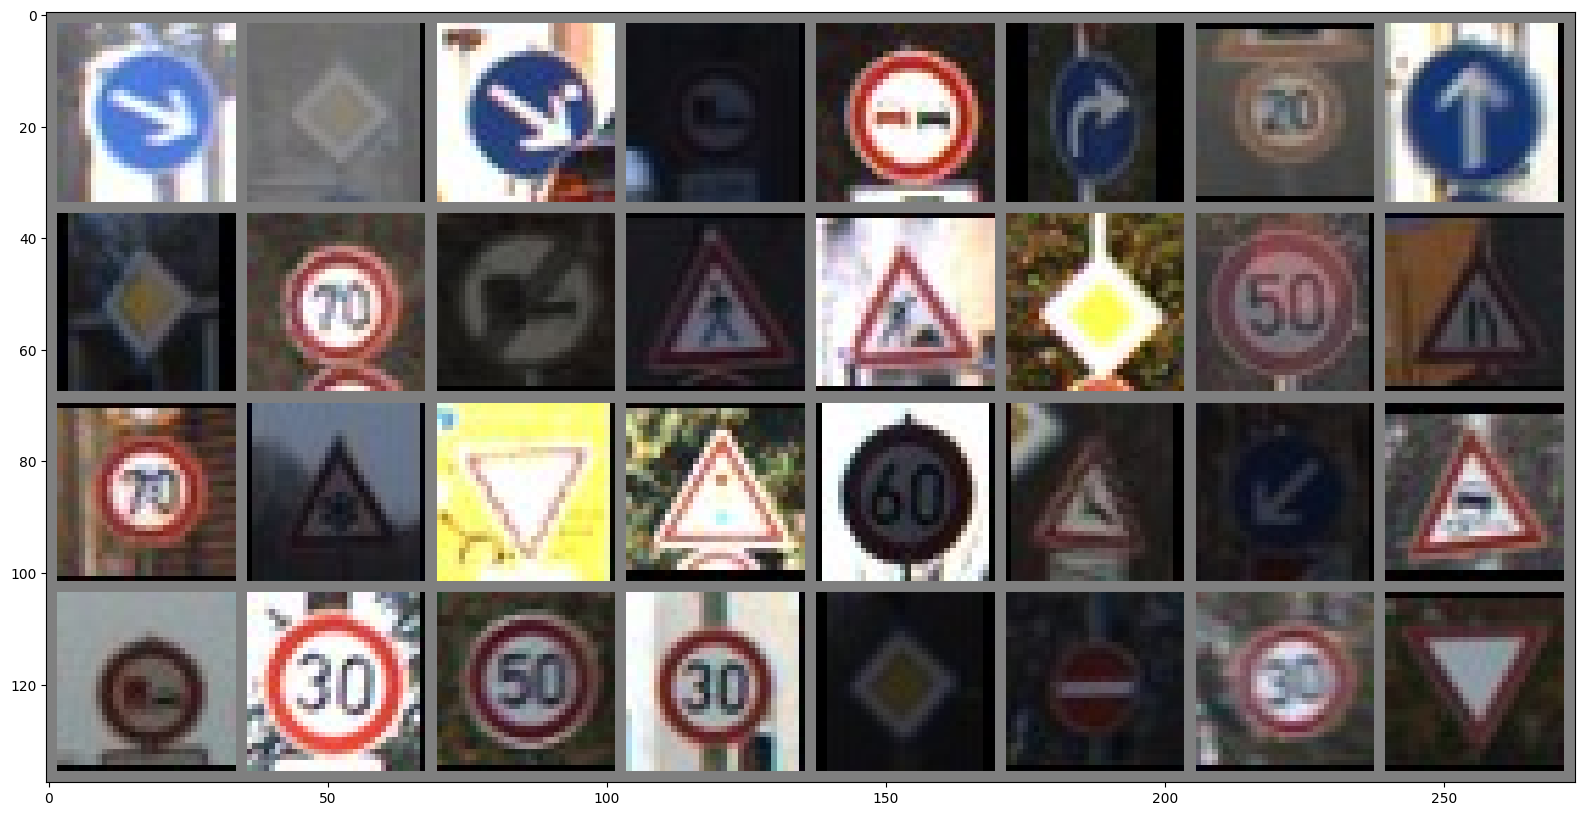

['00038', '00012', '00038', '00010', '00009', '00033', '00000', '00035', '00012', '00004', '00042', '00027', '00025', '00012', '00002', '00024', '00004', '00030', '00013', '00026', '00003', '00031', '00039', '00023', '00010', '00001', '00002', '00001', '00012', '00017', '00001', '00013']


In [5]:
plt.figure(figsize = (20,10))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(list(dataset.classes[labels[j]] for j in range(batch_size)))

In [6]:
images.size()

torch.Size([32, 3, 32, 32])

## Generative Adversarial Networks


In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [9]:
# Models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=3072).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=3072).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [10]:
fixed_noise = torch.randn(16, latent_dim,device=device)

Epoch: 0, discrimiantor fake error: 0.0106, discriminator real acc: 0.972


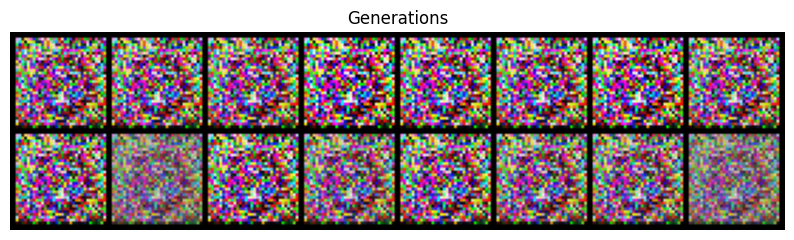

Epoch: 1, discrimiantor fake error: 0.00359, discriminator real acc: 0.991
Epoch: 2, discrimiantor fake error: 0.00325, discriminator real acc: 0.994
Epoch: 3, discrimiantor fake error: 0.00331, discriminator real acc: 0.995
Epoch: 4, discrimiantor fake error: 0.00534, discriminator real acc: 0.995
Epoch: 5, discrimiantor fake error: 0.00789, discriminator real acc: 0.994
Epoch: 6, discrimiantor fake error: 0.00837, discriminator real acc: 0.994
Epoch: 7, discrimiantor fake error: 0.00634, discriminator real acc: 0.995
Epoch: 8, discrimiantor fake error: 0.00413, discriminator real acc: 0.995
Epoch: 9, discrimiantor fake error: 0.0052, discriminator real acc: 0.996
Epoch: 10, discrimiantor fake error: 0.0051, discriminator real acc: 0.996


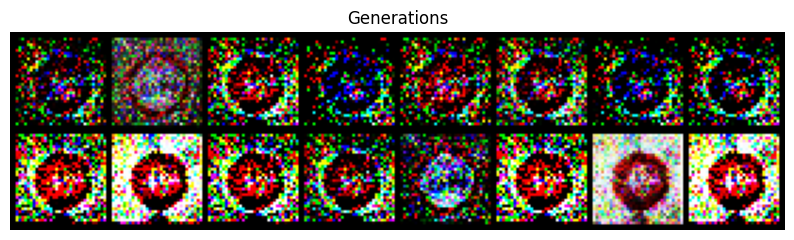

Epoch: 11, discrimiantor fake error: 0.00461, discriminator real acc: 0.996
Epoch: 12, discrimiantor fake error: 0.00412, discriminator real acc: 0.996
Epoch: 13, discrimiantor fake error: 0.00446, discriminator real acc: 0.996
Epoch: 14, discrimiantor fake error: 0.00501, discriminator real acc: 0.996
Epoch: 15, discrimiantor fake error: 0.00624, discriminator real acc: 0.995
Epoch: 16, discrimiantor fake error: 0.00557, discriminator real acc: 0.994
Epoch: 17, discrimiantor fake error: 0.0049, discriminator real acc: 0.995
Epoch: 18, discrimiantor fake error: 0.00543, discriminator real acc: 0.995
Epoch: 19, discrimiantor fake error: 0.00461, discriminator real acc: 0.996
Epoch: 20, discrimiantor fake error: 0.00518, discriminator real acc: 0.995


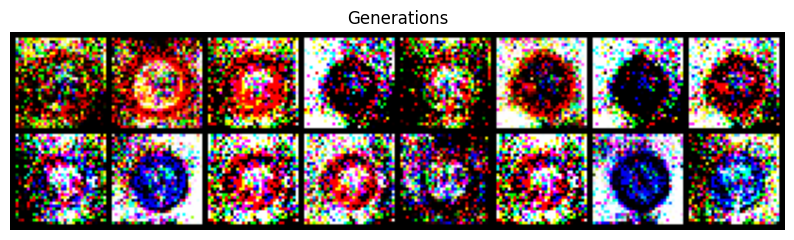

Epoch: 21, discrimiantor fake error: 0.00477, discriminator real acc: 0.995
Epoch: 22, discrimiantor fake error: 0.0046, discriminator real acc: 0.996
Epoch: 23, discrimiantor fake error: 0.00516, discriminator real acc: 0.995
Epoch: 24, discrimiantor fake error: 0.00525, discriminator real acc: 0.995
Epoch: 25, discrimiantor fake error: 0.00567, discriminator real acc: 0.995
Epoch: 26, discrimiantor fake error: 0.00465, discriminator real acc: 0.995
Epoch: 27, discrimiantor fake error: 0.0043, discriminator real acc: 0.996
Epoch: 28, discrimiantor fake error: 0.00416, discriminator real acc: 0.996
Epoch: 29, discrimiantor fake error: 0.00417, discriminator real acc: 0.996
Epoch: 30, discrimiantor fake error: 0.00374, discriminator real acc: 0.996


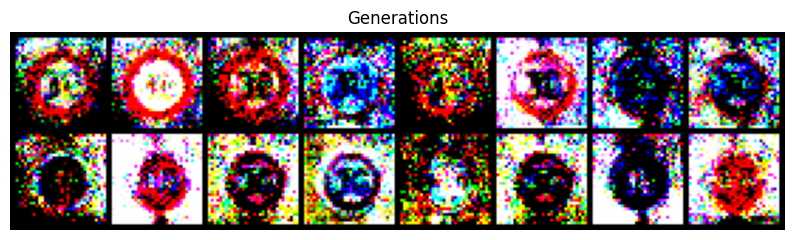

Epoch: 31, discrimiantor fake error: 0.00337, discriminator real acc: 0.996
Epoch: 32, discrimiantor fake error: 0.0035, discriminator real acc: 0.996
Epoch: 33, discrimiantor fake error: 0.00367, discriminator real acc: 0.996
Epoch: 34, discrimiantor fake error: 0.00378, discriminator real acc: 0.996
Epoch: 35, discrimiantor fake error: 0.00319, discriminator real acc: 0.997
Epoch: 36, discrimiantor fake error: 0.00318, discriminator real acc: 0.997
Epoch: 37, discrimiantor fake error: 0.00311, discriminator real acc: 0.997
Epoch: 38, discrimiantor fake error: 0.00345, discriminator real acc: 0.997
Epoch: 39, discrimiantor fake error: 0.00328, discriminator real acc: 0.997
Epoch: 40, discrimiantor fake error: 0.00335, discriminator real acc: 0.997


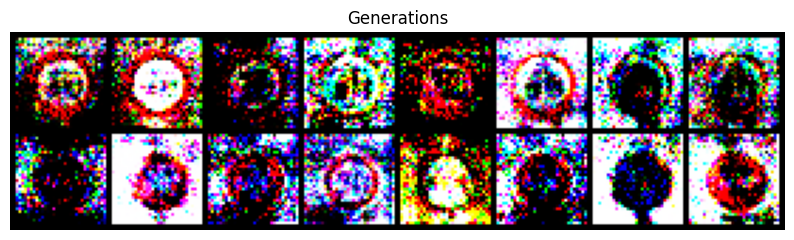

Epoch: 41, discrimiantor fake error: 0.00276, discriminator real acc: 0.997
Epoch: 42, discrimiantor fake error: 0.00299, discriminator real acc: 0.997
Epoch: 43, discrimiantor fake error: 0.00294, discriminator real acc: 0.997
Epoch: 44, discrimiantor fake error: 0.0028, discriminator real acc: 0.997
Epoch: 45, discrimiantor fake error: 0.00264, discriminator real acc: 0.997
Epoch: 46, discrimiantor fake error: 0.00249, discriminator real acc: 0.997
Epoch: 47, discrimiantor fake error: 0.00283, discriminator real acc: 0.997
Epoch: 48, discrimiantor fake error: 0.00241, discriminator real acc: 0.998
Epoch: 49, discrimiantor fake error: 0.00269, discriminator real acc: 0.997
Epoch: 50, discrimiantor fake error: 0.00272, discriminator real acc: 0.997


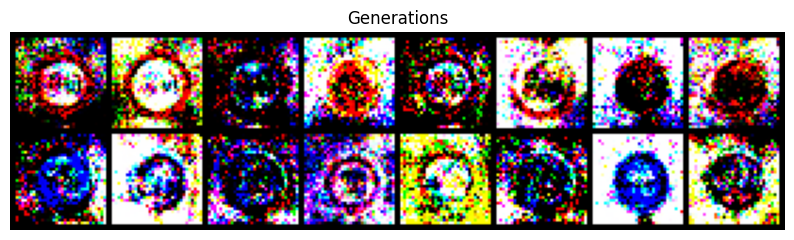

Epoch: 51, discrimiantor fake error: 0.00272, discriminator real acc: 0.997
Epoch: 52, discrimiantor fake error: 0.00235, discriminator real acc: 0.997
Epoch: 53, discrimiantor fake error: 0.00226, discriminator real acc: 0.998
Epoch: 54, discrimiantor fake error: 0.00231, discriminator real acc: 0.998
Epoch: 55, discrimiantor fake error: 0.00269, discriminator real acc: 0.997
Epoch: 56, discrimiantor fake error: 0.00252, discriminator real acc: 0.998
Epoch: 57, discrimiantor fake error: 0.00228, discriminator real acc: 0.998
Epoch: 58, discrimiantor fake error: 0.00229, discriminator real acc: 0.998
Epoch: 59, discrimiantor fake error: 0.00211, discriminator real acc: 0.998
Epoch: 60, discrimiantor fake error: 0.00206, discriminator real acc: 0.998


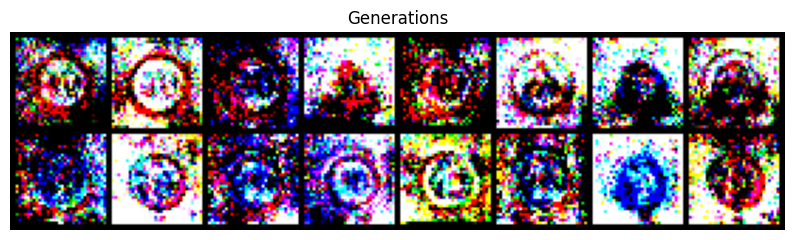

Epoch: 61, discrimiantor fake error: 0.00218, discriminator real acc: 0.998
Epoch: 62, discrimiantor fake error: 0.00199, discriminator real acc: 0.998
Epoch: 63, discrimiantor fake error: 0.00202, discriminator real acc: 0.998
Epoch: 64, discrimiantor fake error: 0.00219, discriminator real acc: 0.998
Epoch: 65, discrimiantor fake error: 0.00199, discriminator real acc: 0.998
Epoch: 66, discrimiantor fake error: 0.00201, discriminator real acc: 0.998
Epoch: 67, discrimiantor fake error: 0.00213, discriminator real acc: 0.998
Epoch: 68, discrimiantor fake error: 0.00192, discriminator real acc: 0.998
Epoch: 69, discrimiantor fake error: 0.00189, discriminator real acc: 0.998
Epoch: 70, discrimiantor fake error: 0.00189, discriminator real acc: 0.998


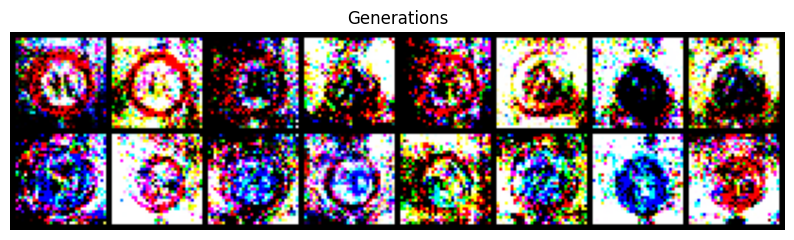

Epoch: 71, discrimiantor fake error: 0.00175, discriminator real acc: 0.998
Epoch: 72, discrimiantor fake error: 0.00171, discriminator real acc: 0.998
Epoch: 73, discrimiantor fake error: 0.00182, discriminator real acc: 0.998
Epoch: 74, discrimiantor fake error: 0.00187, discriminator real acc: 0.998
Epoch: 75, discrimiantor fake error: 0.00184, discriminator real acc: 0.998
Epoch: 76, discrimiantor fake error: 0.00172, discriminator real acc: 0.998
Epoch: 77, discrimiantor fake error: 0.0018, discriminator real acc: 0.998
Epoch: 78, discrimiantor fake error: 0.00158, discriminator real acc: 0.998
Epoch: 79, discrimiantor fake error: 0.00177, discriminator real acc: 0.998
Epoch: 80, discrimiantor fake error: 0.00165, discriminator real acc: 0.998


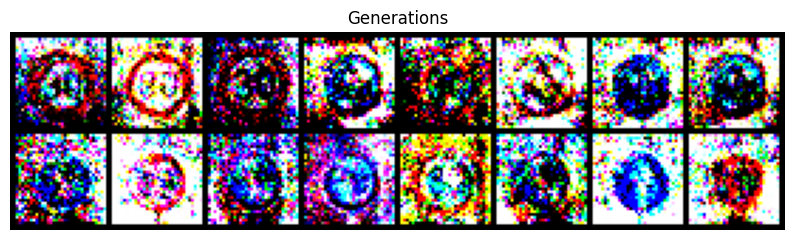

Epoch: 81, discrimiantor fake error: 0.00157, discriminator real acc: 0.998
Epoch: 82, discrimiantor fake error: 0.00152, discriminator real acc: 0.998
Epoch: 83, discrimiantor fake error: 0.00154, discriminator real acc: 0.998
Epoch: 84, discrimiantor fake error: 0.00145, discriminator real acc: 0.998
Epoch: 85, discrimiantor fake error: 0.00144, discriminator real acc: 0.998
Epoch: 86, discrimiantor fake error: 0.00149, discriminator real acc: 0.998
Epoch: 87, discrimiantor fake error: 0.00143, discriminator real acc: 0.998
Epoch: 88, discrimiantor fake error: 0.00151, discriminator real acc: 0.998
Epoch: 89, discrimiantor fake error: 0.00154, discriminator real acc: 0.999
Epoch: 90, discrimiantor fake error: 0.00152, discriminator real acc: 0.998


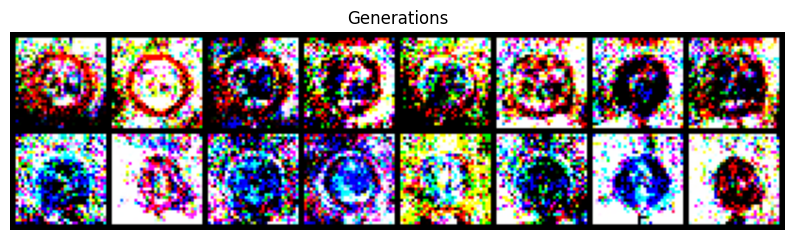

Epoch: 91, discrimiantor fake error: 0.00152, discriminator real acc: 0.998
Epoch: 92, discrimiantor fake error: 0.00161, discriminator real acc: 0.998
Epoch: 93, discrimiantor fake error: 0.00175, discriminator real acc: 0.998
Epoch: 94, discrimiantor fake error: 0.00167, discriminator real acc: 0.998
Epoch: 95, discrimiantor fake error: 0.00142, discriminator real acc: 0.999
Epoch: 96, discrimiantor fake error: 0.00139, discriminator real acc: 0.999
Epoch: 97, discrimiantor fake error: 0.00132, discriminator real acc: 0.999
Epoch: 98, discrimiantor fake error: 0.0014, discriminator real acc: 0.999
Epoch: 99, discrimiantor fake error: 0.00131, discriminator real acc: 0.999


In [11]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        error_discriminator.backward()
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

In [ ]:
with torch.no_grad():
    fake = generator(fixed_noise).detach().cpu()
grid = torchvision.utils.make_grid(fake)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(10,10))
plt.title(f"Generations")
plt.imshow(grid)
plt.axis('off')
plt.show()